# SDMD simulations

To install all required packages and dependencies, run the following cell (only needs to be run once):

In [1]:
using Pkg
Pkg.add("NBInclude")  

using NBInclude
@nbinclude("./Environment/Setup.ipynb");

Environment and modelling functions activation (to be run at the start of the session)

In [2]:
using Pkg
Pkg.activate("./Environment/")
Pkg.instantiate()

include("SDMDModel.jl")

  Activating project at `c:\Users\ov22\OneDrive - Imperial College London\Julia modelling\SDMD\Environment`


#62 (generic function with 1 method)

Preliminary settings

In [3]:
Random.seed!(1234);

In [4]:
N0=10^15   #Effective population size
rep=100    #nunber of runs in simulations

#SDMD construct
#c_=cleavage rate, j_= rate of NHEJ given cleavage, b_=rate of functional resistant mutations given NHEJ
r_SDMD=0.914;c_SDMD=0.7556;j_SDMD=0.0206;b_SDMD=0.0016;

#SDGD construct
r_SDGD=0.93;c_SDGD=0.9576;j_SDGD=0.0392;b_SDGD=0.0016;

#Gene drive baseline construct
r_GD=0.5;c_GD=0.966;j_GD=0.035;b_GD=0.0016;

#Gametes production matrices
E_dx=E_Make(;c_m=c_SDMD,j_m=j_SDMD,a_m=0,b_m=b_SDMD,c_f=c_SDMD,j_f=j_SDMD,a_f=0,b_f=b_SDMD,M=4)
E_SDGD=E_Make(;c_m=c_SDGD,j_m=j_SDGD,a_m=0,b_m=b_SDGD,c_f=c_SDGD,j_f=j_SDGD,a_f=0,b_f=b_SDGD,M=4)
E_GD=E_Make(;c_m=c_GD,j_m=j_GD,a_m=0,b_m=b_GD,c_f=c_GD,j_f=j_GD,a_f=0,b_f=b_GD,M=4);

In [ ]:
# Probability vector for the ability to blood-feed for different genotypes (used for SDMD only)
# N=R2, R=R1
SDMD_wf=repeat([1.0],10)
namesG=["WW","WD","WR2","WR1","DD","DR2","DR1","R2R2","R2R1","R1R1"]
SDMD_wf[findall(x->x=="WD",namesG)].=0.5
SDMD_wf[findall(x->x=="DR1",namesG)].=0.85
SDMD_wf[findall(x->x in ["DD","DR2","R2R2"],namesG)].=0;

In [6]:
using CairoMakie
set_theme!(theme_minimal()) 

colSDMD=(cgrad(:winter, categorical=true,3)[1],0.6)
cols3=[:black,:grey,colSDMD]

labelt= ["GD","SDGD","SDMD"]
marks=[:star5,:cross,:circle] 
lnst=[:solid,:solid,:solid];

In [ ]:
#Running simulations for 3 strategies
#r1 - sex distortion, Nvec = vector of the population sizes

Runs_Nosp_dx=function(;N,r1,rep=500,C=0.9,B=0.001,J=0.05,F=12,hf,hDR=0,hN=0,hm,A=0,maxgen=400,Release=0.01,filename1="dx",homing=:b,beta=0,M=4,Model=2,inter=true,wf_nb=[],dir="")
    N_temp1=[]    #full model output
    N_tempF=[]    #female population (fertile)
    N_tempI=[]    #itegrated suppression area 

    M2=Int(M*(M+1)/2)
    e = E_Make(;c_m=C,c_f=C,j_m=J,j_f=J,b_m=B,b_f=B,a_f=A,a_m=A,M=M,homing=:b)
    wmf=Fitness_input1(;sigma=0,s=1,h=hf,hN=hN,hDR=hDR,hm=hm,show=false,M=M,inter=inter, wf_nb=wf_nb)

    fn1=string(dir,filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    fn2=string(dir,"F",filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    fn3=string(dir,"Int",filename1,"_m",r1,"_hf",hf,"_hN",hN,"_hm",hm,"_A",A,"_C",C,"_B",B,"_J",J,".jld2")
    @showprogress for rp in 1:rep
        sleep(0.1)

        mod1=Model_nosp_NT(;N=N,wmf=wmf,e=e,mD_sex=r1,M=M,maxgen=maxgen,beta=beta,pm=Release)
        n=mod1[1]
        push!(N_tempI,IntegralCum(;dat=n,n=n[1]*2))
        push!(N_tempF,n)
        push!(N_temp1,mod1)
    end
    jldsave(fn1, true; models1=N_temp1)   #save outputs
    jldsave(fn2, true; models1=N_tempF) 
    jldsave(fn3, true; models1=N_tempI) 
    return N_tempF,N_tempI
end

#73 (generic function with 1 method)

Run simulations for idealised parameters

In [8]:
IdealisedRuns=[
    Runs_Nosp_dx(;N=N0,r1=0.5,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=0,hN=0,hm=0,A=0,filename1="dgd"), #GD

    Runs_Nosp_dx(;N=N0,r1=0.95,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=0,hN=0,hm=0,A=0,filename1="dsdgd") ,#SDGD

    Runs_Nosp_dx(;N=N0,r1=0.95,rep=rep,C=0.95,B=0.005,J=0.035,F=12,hf=1,hN=0,hm=0,A=0,inter=false, wf_nb=SDMD_wf,filename1="dx") ,#SDMD 

];
#Duration of protection 
p=0.5
TRest_095= [mean([TimePerc(IdealisedRuns[h][1][i];perc=p)[2]-TimePerc(IdealisedRuns[h][1][i];perc=p)[1] for i in 1:rep]) for h in eachindex(IdealisedRuns)];


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


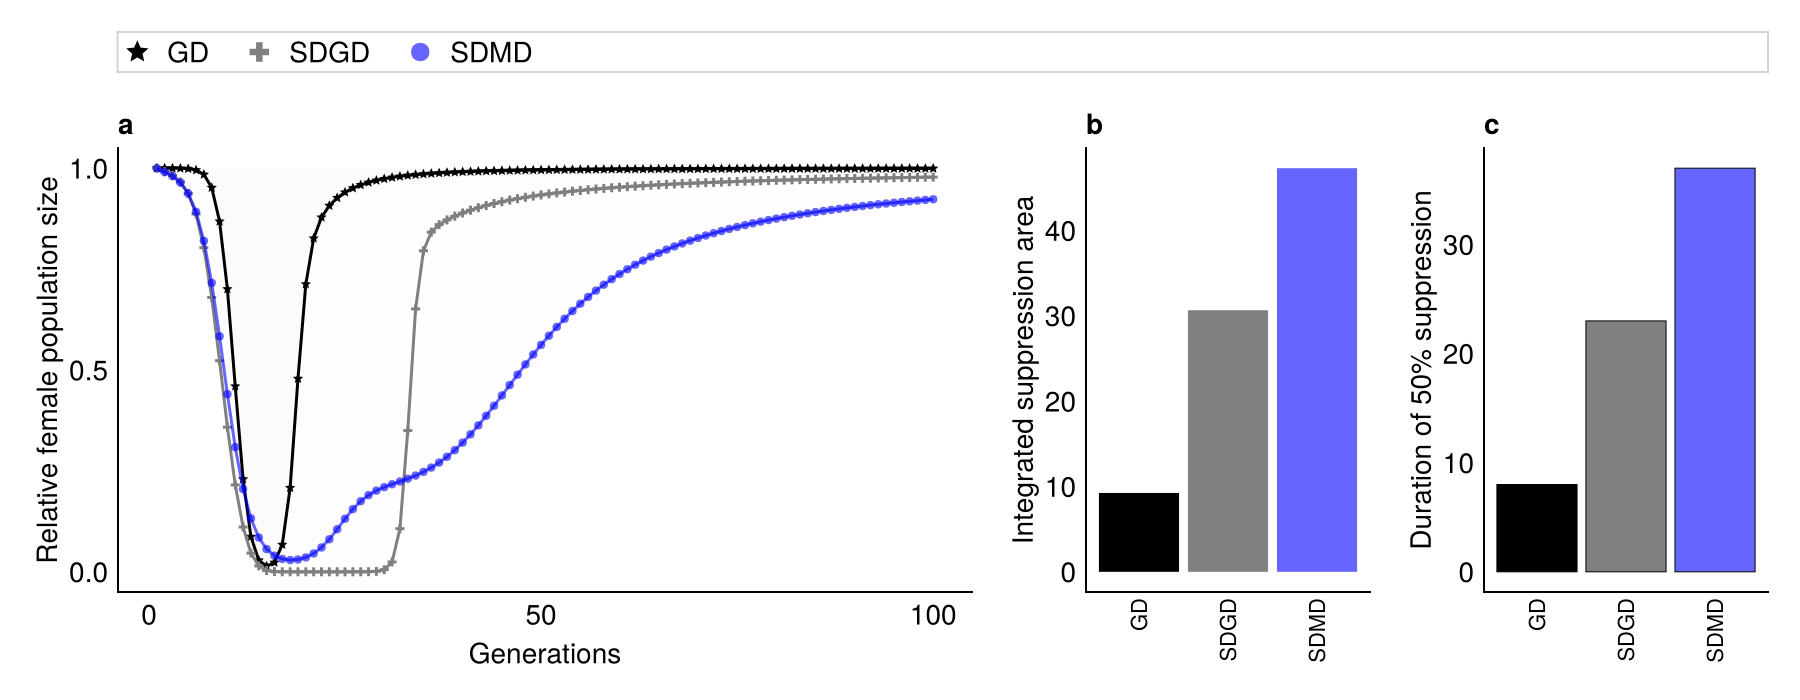

In [ ]:
#IMPACT OF THE FITNESS ON THE POPULATION DYNAMICS (SEX DISTORTION=0.9, 0.99)
#b = 0.005, and HNEJ rates j= 0.035
f=Figure(size=(900,350))
#supertitle=Label(f[0,1:3], "Sex distortion and W/D female fitness effects on population suppression",fontsize=16,halign=:left)
ax1=Axis(f[1,1],title="a",titlealign=:left,ylabel="Relative female population size",xlabel="Generations")
gen=100

n=N0
mods=first.(IdealisedRuns) #population
modsI=last.(IdealisedRuns) #integrated area

for i in 1:3
    scatterlines!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]) ,color=cols3[i],marker=marks[i],markersize=6)
    band!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]),repeat([1],gen),alpha=0.1,color=(cols3[i],0.1),label=labelt[i])

end


ax2=Axis(f[1,2],title="b  ",ylabel="Integrated suppression area",xticks=(1:3,labelt),xticklabelrotation=pi/2,titlealign=:left,xticklabelsize=11)
is=[modsI[i][1][end] for i in 1:3]
barplot!(ax2,1:3,is,color=cols3,gap=0.1,strokecolor = :black, strokewidth = 0)#,direction=:x,color=col66)


ax3=Axis(f[1,3],title="c  ",ylabel="Duration of 50% suppression",xticks=(1:3,labelt),xticklabelrotation=pi/2,titlealign=:left,xticklabelsize=11)
ts=[TRest_095[i] for i in 1:3]
barplot!(ax3,1:3,ts,color=cols3,gap=0.1,strokecolor = :black, strokewidth = 0.5)

leg=[MarkerElement(color = cols3[i],markersize=13,marker=marks[i]) for i in 1:3];
Legend(f[0, 1:3], leg, ["GD","SDGD","SDMD"],titleposition=:left,orientation = :horizontal,padding=(0,0,0,0),halign=:left,colgap =15,tellwidth=false)#,framecolor=:lightgrey,framevisible=true)
Box(f[0, 1:3],color=(:white,0),strokewidth = 1,strokecolor=:lightgrey)

colsize!(f.layout, 1, Relative(3.6/6))
colsize!(f.layout, 2, Relative(1.2/6))
colsize!(f.layout, 3, Relative(1.2/6))
save("SDMDFigure1_idealised.png",f)
f

In [21]:
b=0.0016
EmpiricalRuns=
    [Runs_Nosp_dx(;N=N0,r1=0.5,rep=rep,C=c_GD,B=b,J=j_GD,F=12,hf=0,hN=0,hm=0,A=0,filename1="gdEmpB"),
     Runs_Nosp_dx(;N=N0,r1=r_SDGD,rep=rep,C=c_SDGD,B=b,J=j_SDGD,F=12,hf=0.38,hN=0,hm=0,A=0,filename1="sdgdEmpB"),
     Runs_Nosp_dx(;N=N0,r1=r_SDMD,rep=rep,C=c_SDMD,B=b,J=j_SDMD,F=12,hf=1,hDR=1,hN=0,hm=0,A=0,filename1="dxEmpB")
    ];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


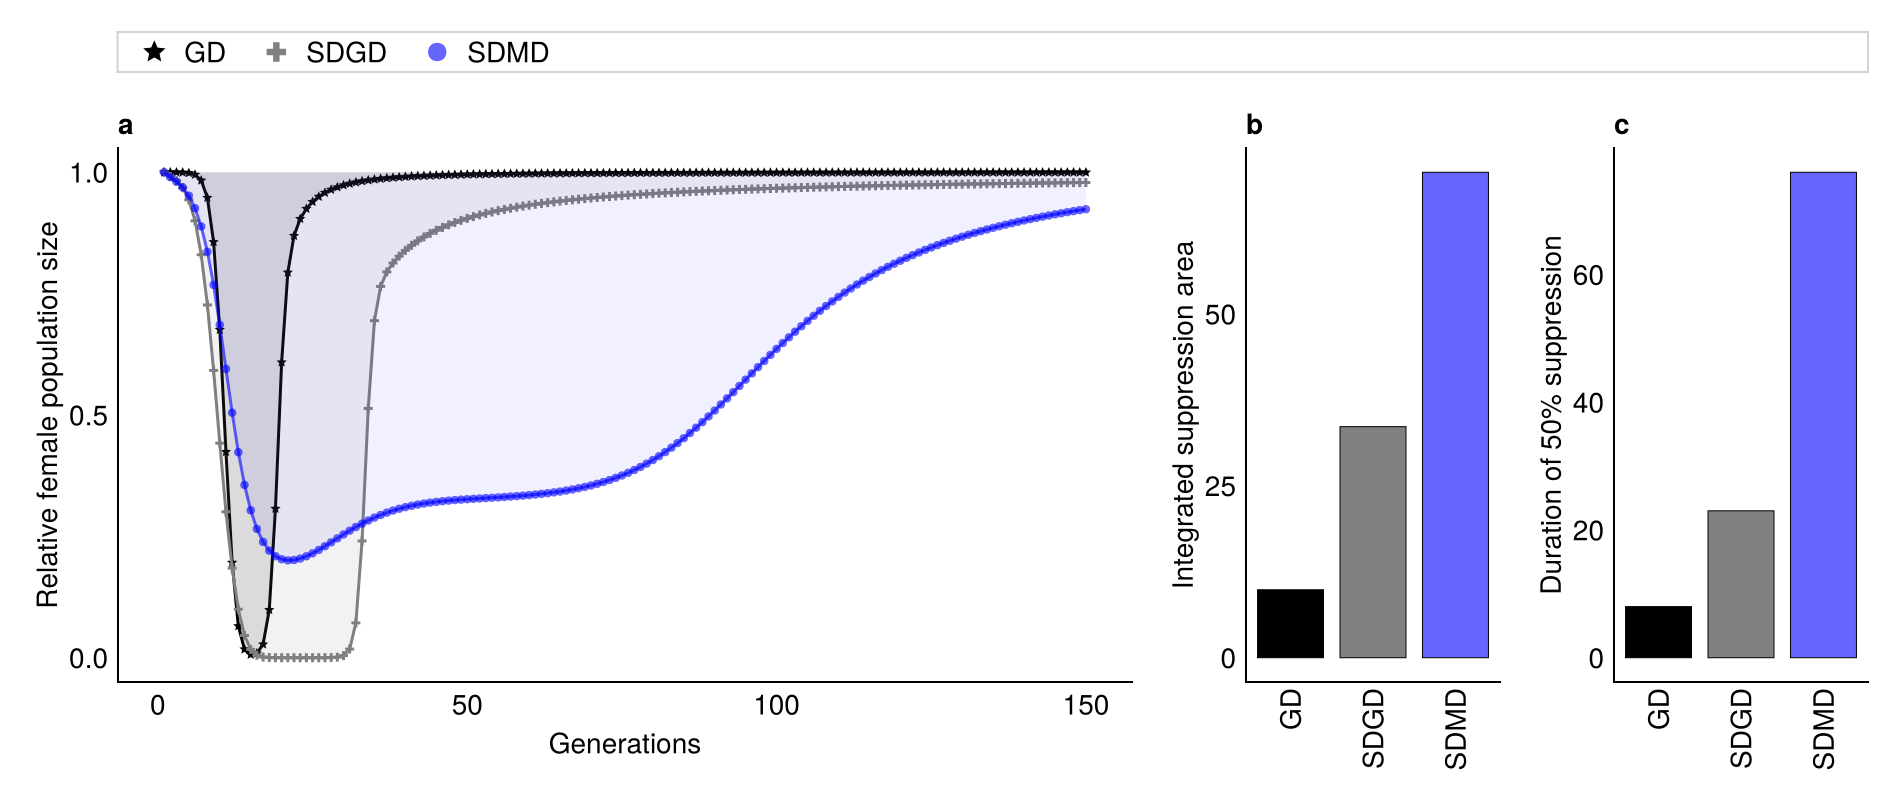

In [ ]:
p=0.5
#DYNAMICS, INTEGRATED SUPPRESSION AREA AND DURATION OF PROTECTION FOR 3 EMPIRICAL CONSTRUCTS
f=Figure(size=(950,400))

n=N0
gen=150
mods=first.(EmpiricalRuns)
modsI=last.(EmpiricalRuns)

ax1=Axis(f[1,1],title="a ", ylabel="Relative female population size",xlabel="Generations",titlealign=:left)
for i in 1:3
    scatterlines!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]) ,color=cols3[i],marker=marks[i],markersize=6)
    band!(ax1,1:gen,mean([mods[i][j][1:gen]./(0.5*n) for j in 1:rep]),repeat([1],gen),alpha=0.1,color=(cols3[i],0.1),label=labelt[i])

end

ax2=Axis(f[1,2],title="b  ",ylabel="Integrated suppression area",xticks=(1:3,["GD","SDGD","SDMD"]),xticklabelrotation=pi/2,titlealign=:left)

y=[mean([modsI[i][j][end] for j in 1:rep]) for i in 1:3]

barplot!(ax2,1:3, y,color=cols3,strokecolor = :black, strokewidth = 0.5)
ax3=Axis(f[1,3],title="c  ",ylabel="Duration of 50% suppression",xticks=(1:3,["GD","SDGD","SDMD"]),titlealign=:left,xticklabelrotation=pi/2)
TRestEmp= [TimePerc(mods[i][1];perc=p)[2]-TimePerc(mods[i][1];perc=p)[1] for i in 1:3];
barplot!(ax3,1:3,TRestEmp[1:3],color=cols3,strokecolor = :black, strokewidth = 0.5)#,direction=:x)

colsize!(f.layout, 1, Relative(4/6))
colsize!(f.layout, 2, Relative(1/6))
colsize!(f.layout, 2, Relative(1/6))

leg=[MarkerElement(color = cols3[i],markersize=13,marker=marks[i]) for i in 1:3];
Legend(f[0, 1:3], leg, ["GD","SDGD","SDMD"],"",titleposition=:left,orientation = :horizontal,padding=(0,0,0,0),halign=:left,colgap =15,tellwodth=false)#,framecolor=:lightgrey,framevisible=true)
Box(f[0, 1:3],color=(:white,0),strokewidth = 1,strokecolor=:lightgrey)

save("SDMDFigure2empirical.png",f)
f